In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from scipy.stats import randint

# For text preprocessing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
from nltk import pos_tag


# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')


# For dataset loading
from sklearn.datasets import fetch_20newsgroups


# Set random seed for reproducibility
np.random.seed(42)


# Load a subset of the 20 Newsgroups dataset
categories = ['comp.graphics', 'rec.autos', 'sci.space', 'talk.politics.misc']
newsgroups = fetch_20newsgroups(subset='train', categories=categories, random_state=42)


# Create a DataFrame for easier manipulation
df = pd.DataFrame({
   'text': newsgroups.data,
   'category': [newsgroups.target_names[target] for target in newsgroups.target]
})


# Preview the data
print(f"Dataset shape: {df.shape}")
print("\nCategory distribution:")
print(df['category'].value_counts())
print("\nSample document:")
print(df['text'][10][:500])  # Print first 500 characters of a sample document

Dataset shape: (2236, 2)

Category distribution:
category
rec.autos             594
sci.space             593
comp.graphics         584
talk.politics.misc    465
Name: count, dtype: int64

Sample document:
From: bob1@cos.com (Bob Blackshaw)
Subject: Re: Dumbest Driver Action
Organization: Corporation for Open Systems
Distribution: usa 
Lines: 41

In <C5Dq2n.5uB@news.cso.uiuc.edu> mwbg9715@uxa.cso.uiuc.edu (Mark Wayne Blunier) writes:

>jimf@centerline.com (Jim Frost) writes:

>>I wish I had the figures with me to back me up, but I recall
>>statistics showing that women tended to have more accidents than men
>>but the damage was generally quite minor.  Men had fewer but far more
>>expensive acciden


[nltk_data] Downloading package punkt to /Users/sam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/sam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sam/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /Users/sam/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/sam/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [2]:
df.head()

,text,category
0,From: nfotis@ntua.gr (Nick C. Fotis)\nSubject:...,comp.graphics
1,From: cdm@pmafire.inel.gov (Dale Cook)\nSubjec...,talk.politics.misc
2,From: rick@trystro.uucp (Richard Nickle)\nSubj...,sci.space
3,From: marshatt@feserve.cc.purdue.edu (Zauberer...,rec.autos
4,From: Clinton-HQ@Campaign92.Org (Clinton/Gore ...,talk.politics.misc


In [5]:
stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

# Map POS tag to WordNet tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN

class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, lowercase=True, remove_punctuation=True, remove_stopwords=False, lemmatize=False):
        self.lowercase = lowercase
        self.remove_punctuation = remove_punctuation
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize
        
        self.stopwords = None
        self.lemmatizer = None

    def fit(self, X, y=None):
        if self.remove_stopwords and self.stopwords is None:
            self.stopwords = set(stopwords.words('english'))
        if self.lemmatize and self.lemmatizer is None:
            nltk.download('wordnet', quiet=True)
            nltk.download('averaged_perceptron_tagger', quiet=True)
            self.lemmatizer = WordNetLemmatizer()
        return self

    def transform(self, X, y=None):
        cleaned = []
        for doc in X:
            text = doc
            if self.lowercase:
                text = text.lower()
            if self.remove_punctuation:
                text = re.sub(r'[^\w\s]', '', text)
            tokens = text.split()
            if self.remove_stopwords and self.stopwords is not None:
                tokens = [t for t in tokens if t not in self.stopwords]
            if self.lemmatize and self.lemmatizer is not None:
                pos_tags = pos_tag(tokens)
                tokens = [self.lemmatizer.lemmatize(t, get_wordnet_pos(pos)) for t, pos in pos_tags]
            cleaned.append(' '.join(tokens))
        return cleaned

Creating a text cleaner for use later that removes punctuation etc, and can remove stopwords/lemmatize later if needed

In [6]:
df.head()

,text,category
0,From: nfotis@ntua.gr (Nick C. Fotis)\nSubject:...,comp.graphics
1,From: cdm@pmafire.inel.gov (Dale Cook)\nSubjec...,talk.politics.misc
2,From: rick@trystro.uucp (Richard Nickle)\nSubj...,sci.space
3,From: marshatt@feserve.cc.purdue.edu (Zauberer...,rec.autos
4,From: Clinton-HQ@Campaign92.Org (Clinton/Gore ...,talk.politics.misc


In [7]:
cleaner = TextCleaner(remove_stopwords=False, lemmatize=False)
df['processed_tokens'] = cleaner.transform(df['text'])
df['processed_tokens_list'] = df['processed_tokens'].apply(lambda x: x.split())

In [39]:
print(df['text'][4])
print('-' * 40)
print(df['processed_tokens'][4])

#nntppostinghost appears a lot

From: Clinton-HQ@Campaign92.Org (Clinton/Gore '92)
Subject: CLINTON: President's Remarks on Trip to Baltimore 4.5.93
Organization: Project GNU, Free Software Foundation,
    675 Mass. Ave., Cambridge, MA  02139, USA +1 (617) 876-3296
Lines: 74
NNTP-Posting-Host: life.ai.mit.edu






                           THE WHITE HOUSE

                    Office of the Press Secretary

____________________________________________________________________
For Immediate Release                                  April 5, 1993 

                       REMARKS BY THE PRESIDENT
        EN ROUTE TO CAMDEN YARDS FOR ORIOLES OPENING DAY GAME
	     
                              MARC Train
                       En Route to Camden Yards



11:45 A.M. EDT
	     
	     Q	  Mr. President, what do you think of Jesse Jackson's 
protest today?
	     
	     THE PRESIDENT:  I think it's an informational protest.  
I think it's fine.  The owners put out a statement few days ago, 
which they say was the first step i

In [8]:
df.head()

,text,category,processed_tokens,processed_tokens_list
0,From: nfotis@ntua.gr (Nick C. Fotis)\nSubject:...,comp.graphics,from nfotisntuagr nick c fotis subject re more...,"[from, nfotisntuagr, nick, c, fotis, subject, ..."
1,From: cdm@pmafire.inel.gov (Dale Cook)\nSubjec...,talk.politics.misc,from cdmpmafireinelgov dale cook subject re go...,"[from, cdmpmafireinelgov, dale, cook, subject,..."
2,From: rick@trystro.uucp (Richard Nickle)\nSubj...,sci.space,from ricktrystrouucp richard nickle subject re...,"[from, ricktrystrouucp, richard, nickle, subje..."
3,From: marshatt@feserve.cc.purdue.edu (Zauberer...,rec.autos,from marshattfeserveccpurdueedu zauberer subje...,"[from, marshattfeserveccpurdueedu, zauberer, s..."
4,From: Clinton-HQ@Campaign92.Org (Clinton/Gore ...,talk.politics.misc,from clintonhqcampaign92org clintongore 92 sub...,"[from, clintonhqcampaign92org, clintongore, 92..."


In [10]:
counter = Counter([token for doc in df['processed_tokens_list'] for token in doc])
print("Top 20 Unigrams:")
for word, count in counter.most_common(20):
    print(f"{word:15} : {count}")

all_tokens = df['processed_tokens_list'].sum()

# Bigrams
bigram_counts = Counter(ngrams(all_tokens, 2))
print("\nTop 20 Bigrams:")
for bigram, count in bigram_counts.most_common(20):
    print(f"{' '.join(bigram):25} : {count}")

# Trigrams
trigram_counts = Counter(ngrams(all_tokens, 3))
print("\nTop 20 Trigrams:")
for trigram, count in trigram_counts.most_common(20):
    print(f"{' '.join(trigram):35} : {count}")

Top 20 Unigrams:
the             : 29530
to              : 14985
of              : 13861
a               : 13102
and             : 11763
in              : 9983
is              : 8123
i               : 7717
that            : 7516
for             : 6150
it              : 6060
you             : 5046
on              : 4712
from            : 4547
this            : 4050
be              : 3891
are             : 3773
have            : 3720
not             : 3398
with            : 3248

Top 20 Bigrams:
of the                    : 3047
in the                    : 2140
subject re                : 1540
on the                    : 1390
in article                : 1347
to the                    : 1213
to be                     : 994
for the                   : 979
it is                     : 868
that the                  : 823
if you                    : 793
is a                      : 774
and the                   : 768
university of             : 625
with the                  : 623
i have         

In [40]:
# Group tokens by category and flatten the token lists per category
tokens_per_category = df.groupby('category')['processed_tokens_list'].apply(
    lambda lists: [token for sublist in lists for token in sublist]
)

# Show token count for each category
for category, tokens in tokens_per_category.items():
    print(f"Category: {category}")
    print(f"Total tokens: {len(tokens)}")
    print(f"Top 10 tokens: {Counter(tokens).most_common(10)}")
    print("-" * 40)

#As predicted, many stopwords in top counts per cat

Category: comp.graphics
Total tokens: 125834
Top 10 tokens: [('the', 4525), ('to', 2639), ('a', 2626), ('of', 2467), ('and', 2339), ('is', 1742), ('i', 1670), ('in', 1645), ('for', 1594), ('it', 1252)]
----------------------------------------
Category: rec.autos
Total tokens: 130702
Top 10 tokens: [('the', 6070), ('a', 3159), ('to', 2624), ('i', 2400), ('and', 2288), ('of', 2275), ('in', 2081), ('is', 1603), ('it', 1416), ('that', 1385)]
----------------------------------------
Category: sci.space
Total tokens: 172371
Top 10 tokens: [('the', 8252), ('of', 4121), ('to', 3797), ('a', 3489), ('and', 3248), ('in', 2729), ('is', 2062), ('for', 1660), ('that', 1599), ('i', 1417)]
----------------------------------------
Category: talk.politics.misc
Total tokens: 201203
Top 10 tokens: [('the', 10683), ('to', 5925), ('of', 4998), ('and', 3888), ('a', 3828), ('that', 3564), ('in', 3528), ('is', 2716), ('i', 2230), ('it', 2026)]
----------------------------------------


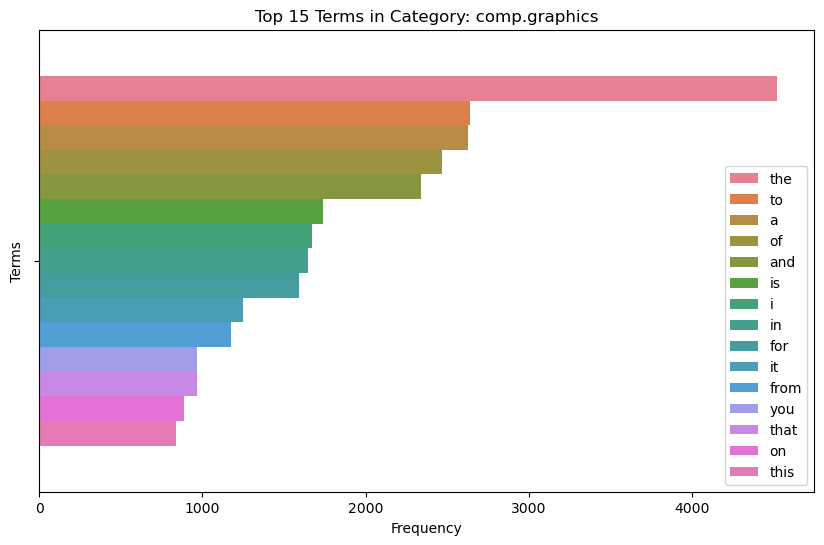

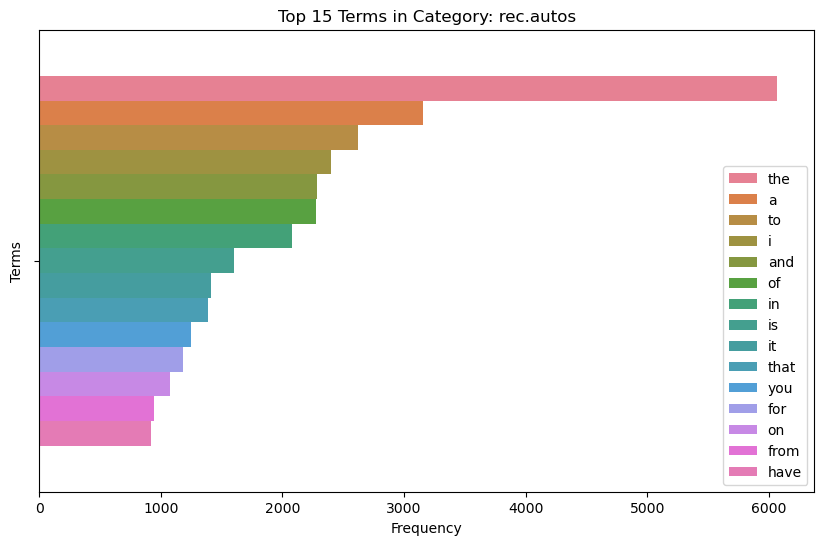

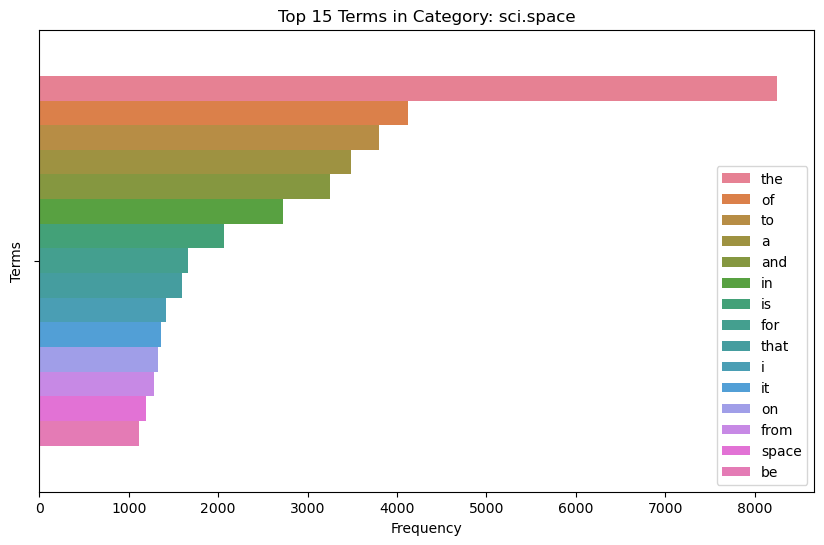

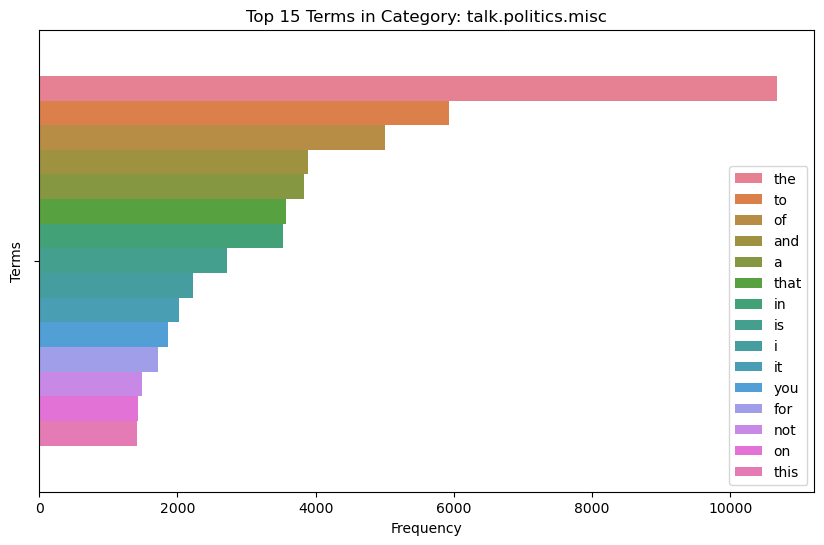

In [15]:
freq_dist = {
    category: Counter(tokens) 
    for category, tokens in tokens_per_category.items()
}

def plot_top_terms(freq_counter, category, n=15):
    common_terms = freq_counter.most_common(n)
    terms, counts = zip(*common_terms)
    plt.figure(figsize=(10,6))
    sns.barplot(x=list(counts), hue=list(terms))
    plt.title(f"Top {n} Terms in Category: {category}")
    plt.xlabel("Frequency")
    plt.ylabel("Terms")
    plt.show()

for cat, counter in freq_dist.items():
    plot_top_terms(counter, cat)

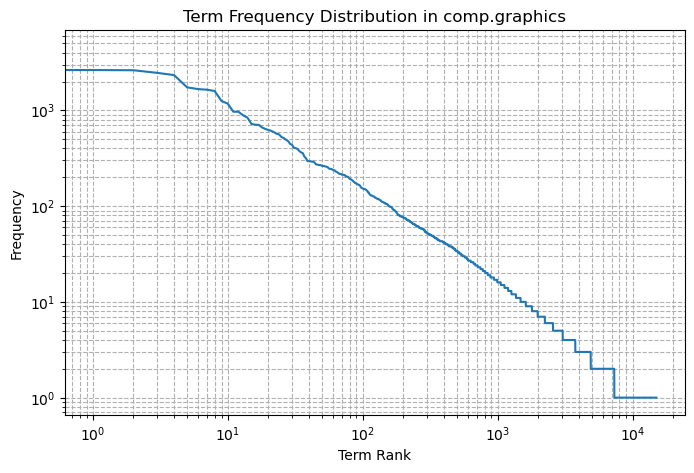

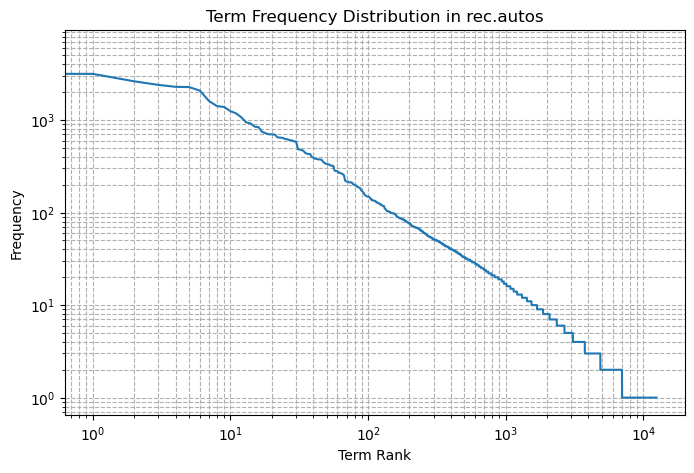

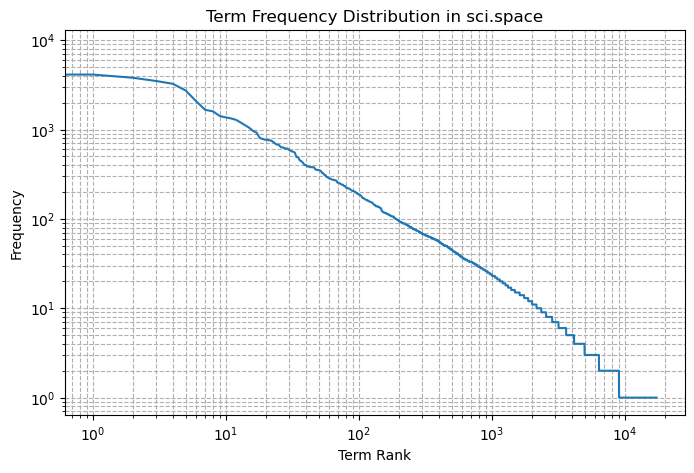

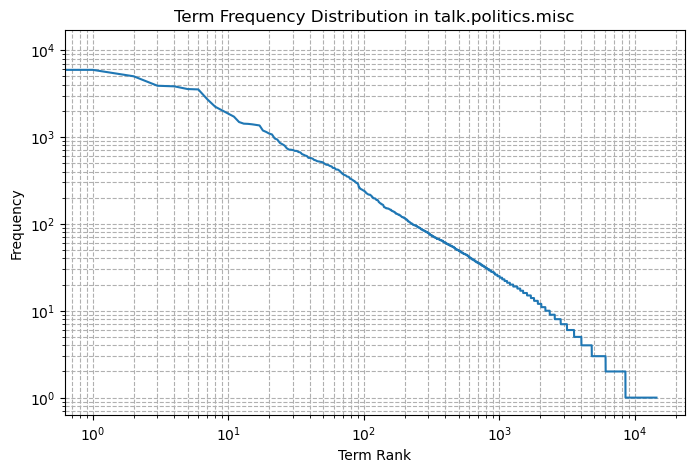

In [16]:
def plot_freq_distribution(freq_counter, category):
    counts = list(freq_counter.values())
    counts.sort(reverse=True)
    
    plt.figure(figsize=(8,5))
    plt.plot(counts)
    plt.title(f"Term Frequency Distribution in {category}")
    plt.ylabel("Frequency")
    plt.xlabel("Term Rank")
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True, which="both", ls="--")
    plt.show()

for cat, counter in freq_dist.items():
    plot_freq_distribution(counter, cat)

Combining all words into each category and looking at their TF-IDF score. High level view of the top words per category

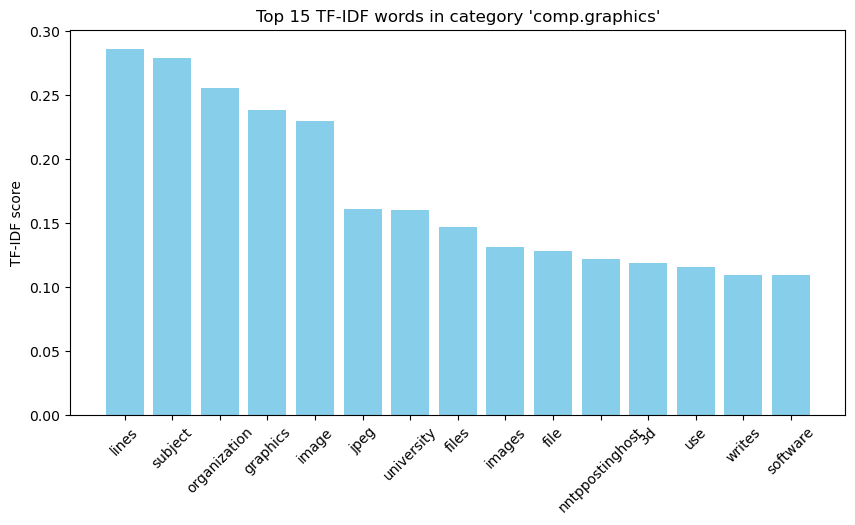

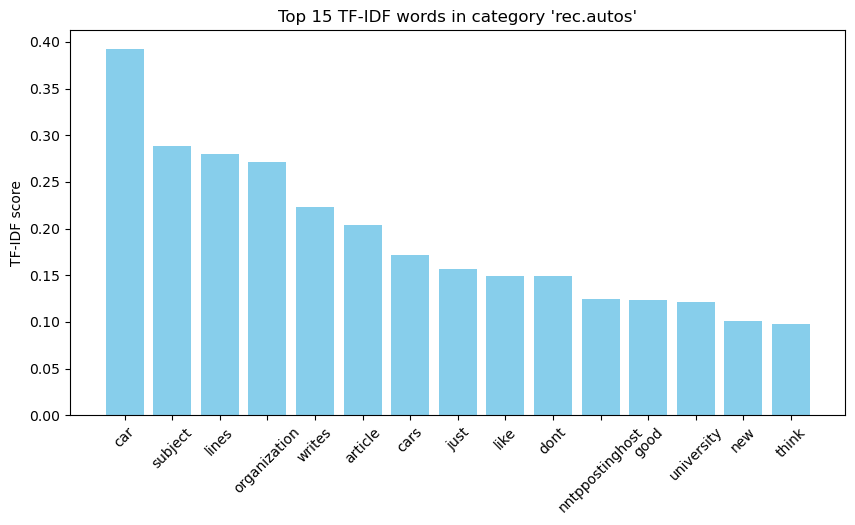

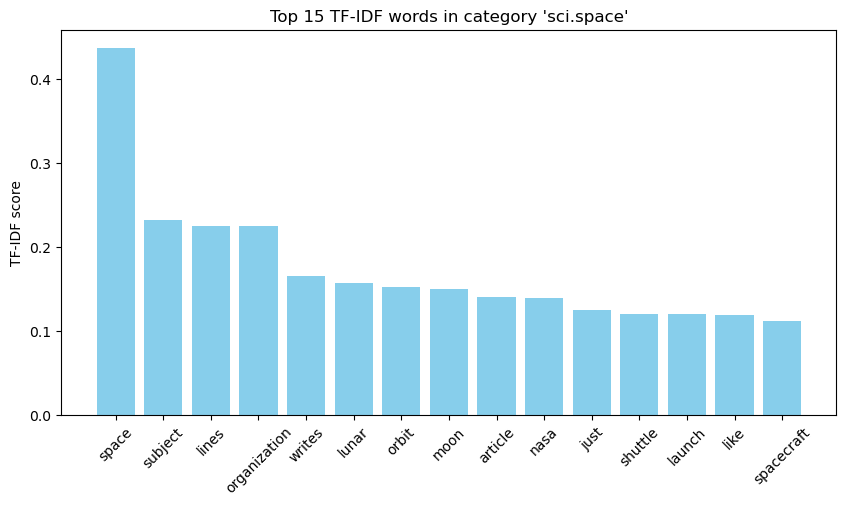

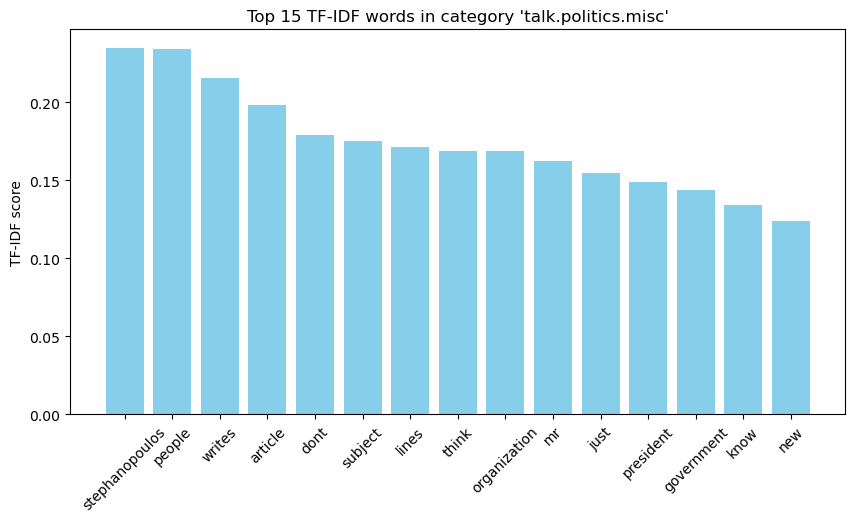

In [18]:
# Combine all texts per category into a single string
category_texts = df.groupby('category')['processed_tokens_list'].apply(
    lambda texts: " ".join([token for tokens_list in texts for token in tokens_list])
)

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)

# Fit and transform on category-level combined texts (each category is one doc)
tfidf_matrix = tfidf.fit_transform(category_texts)

feature_names = np.array(tfidf.get_feature_names_out())

# For each category, get top N terms by TF-IDF score
top_n = 15

for i, category in enumerate(category_texts.index):
    tfidf_scores = tfidf_matrix[i].toarray().flatten()
    top_indices = tfidf_scores.argsort()[::-1][:top_n]
    top_terms = feature_names[top_indices]
    top_scores = tfidf_scores[top_indices]

    plt.figure(figsize=(10,5))
    plt.bar(top_terms, top_scores, color='skyblue')
    plt.title(f"Top {top_n} TF-IDF words in category '{category}'")
    plt.xticks(rotation=45)
    plt.ylabel("TF-IDF score")
    plt.show()

Maybe we can add a filter in the pipeline that removes words that have low STDev (have high TF-IDF score across all categories), but we want to keep the words that generally have very high TF-IDF scores.

In [19]:
class CategoryTfidfFilter(BaseEstimator, TransformerMixin):
    def __init__(self, category_col='category', text_col='joined_processed_text', max_features=1000, enabled=True):
        self.category_col = category_col
        self.text_col = text_col
        self.max_features = max_features
        self.enabled = enabled
        self.selected_features_ = None

    def fit(self, X, y=None):
        # Check input is DataFrame and has required columns
        if self.category_col not in X.columns or self.text_col not in X.columns:
            raise ValueError(f"Input X must contain columns '{self.category_col}' and '{self.text_col}'")

        if self.enabled:
            # Aggregate texts per category, joining token lists into strings first
            category_texts = (
                X.groupby(self.category_col)[self.text_col]
                 .apply(lambda docs: " ".join([" ".join(doc) for doc in docs]))
            )

            # Fit TF-IDF vectorizer on category-level aggregated texts
            vectorizer = TfidfVectorizer(max_features=self.max_features, stop_words='english')
            vectorizer.fit(category_texts)
            self.selected_features_ = set(vectorizer.get_feature_names_out())
        else:
            self.selected_features_ = None

        return self

    def transform(self, X):
        if not self.enabled or self.selected_features_ is None:
            # If filtering disabled, return tokens joined as string
            return X[self.text_col].apply(lambda tokens: " ".join(tokens))

        def filter_tokens(tokens):
            filtered = [t for t in tokens if t in self.selected_features_]
            return " ".join(filtered)

        return X[self.text_col].apply(filter_tokens)

Then let's look at scores but with each email as its own doc

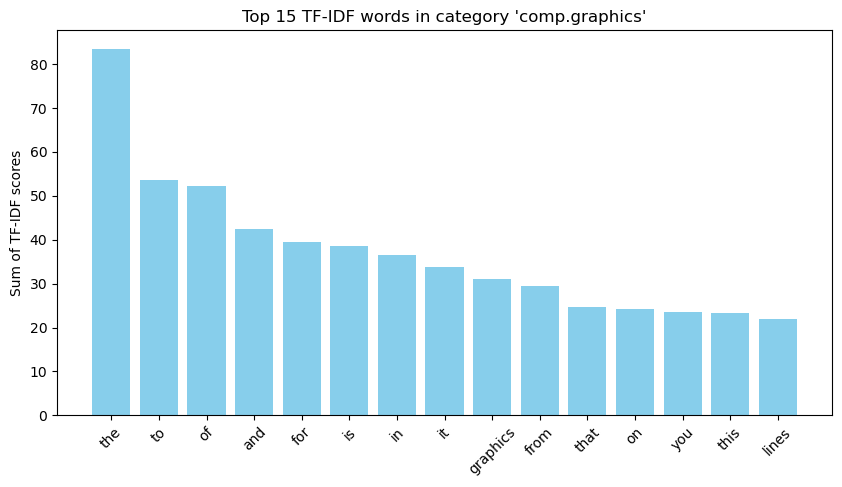

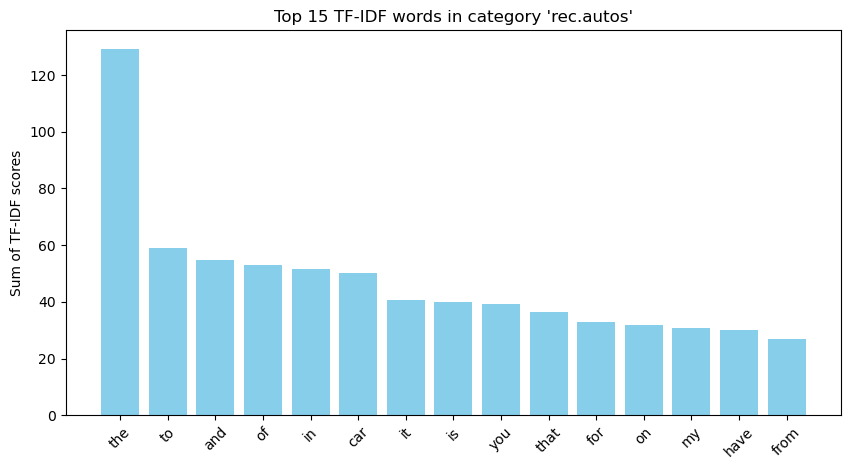

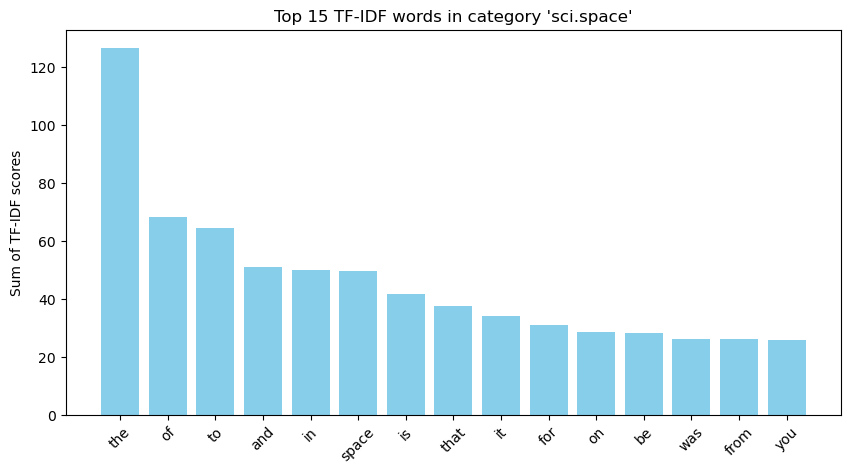

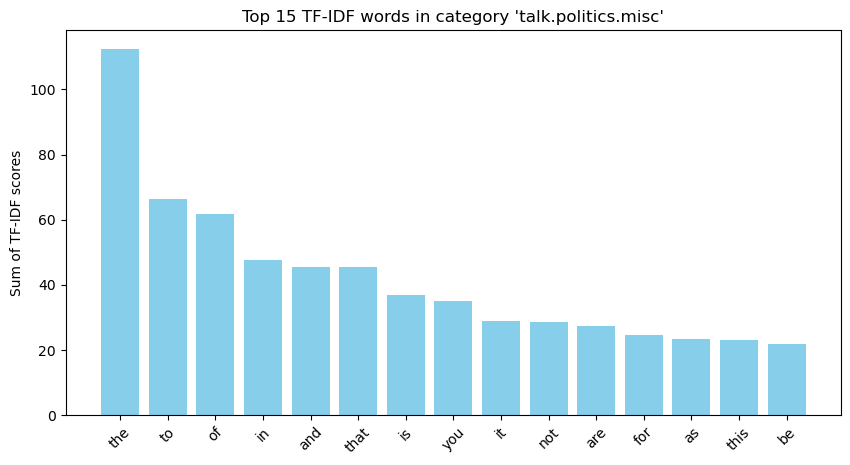

In [41]:
# Initialize TF-IDF vectorizer (you can add stopwords or your own tokenizer)
tfidf = TfidfVectorizer(max_features=1000)

# Fit and transform on all emails (each row is a document)
tfidf_matrix = tfidf.fit_transform(df['processed_tokens'])

# Get feature (word) names
feature_names = np.array(tfidf.get_feature_names_out())

# Create a DataFrame from TF-IDF matrix
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
tfidf_df['category'] = df['category'].values

# Aggregate TF-IDF scores per category (sum TF-IDF scores for each word in each category)
category_tfidf = tfidf_df.groupby('category').sum()

# For each category, get top N words by TF-IDF sum and plot
top_n = 15
for category in category_tfidf.index:
    top_words = category_tfidf.loc[category].sort_values(ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 5))
    plt.bar(top_words.index, top_words.values, color='skyblue')
    plt.title(f"Top {top_n} TF-IDF words in category '{category}'")
    plt.xticks(rotation=45)
    plt.ylabel("Sum of TF-IDF scores")
    plt.show()

In [21]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(max_iter=500))
])

X = df['processed_tokens'].tolist()
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define parameter distribution for RandomizedSearch
param_dist = {
    'tfidf__max_features': randint(500, 3000),                                # random int between 500 and 3000
    'tfidf__ngram_range': [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)],        # unigrams, bigrams, trigrams
    'tfidf__min_df': randint(1, 10),                                          # min document frequency between 1 and 10
    'clf__C': np.logspace(-3, 3, 7),                                          # regularization strength for Logistic Regression
    'clf__penalty': ['l2'],                                                   # penalty type (can add 'l1' with solver='liblinear')
    'clf__solver': ['lbfgs']                                                  # solver compatible with l2 penalty
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Run random search on training data
random_search.fit(X_train, y_train)

print("Best random parameters found:")
best_params = random_search.best_params_
print(best_params)

print(f"Best CV accuracy: {random_search.best_score_:.4f}")

# Evaluate on test set
best_model = random_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

def create_param_grid_around_value(param_name, best_value, scale=0.5, num_points=5, log_scale=True):
    """
    Create a list of values around best_value for grid search.

    - scale: fraction to vary around best_value
    - num_points: how many values to generate in the grid
    - log_scale: whether to create values spaced logarithmically (good for C)
    """
    if log_scale:
        low = best_value / (10 ** scale)
        high = best_value * (10 ** scale)
        grid = np.logspace(np.log10(low), np.log10(high), num_points)
    else:
        low = max(best_value - scale, 1)  # avoid negatives or zero if needed
        high = best_value + scale
        grid = np.linspace(low, high, num_points)

    # Convert to int if original param is int (e.g. max_features)
    if isinstance(best_value, int):
        grid = [int(round(x)) for x in grid]

    return grid

param_grid = {
    'clf__C': create_param_grid_around_value('clf__C', best_params['clf__C'], scale=0.3, num_points=3, log_scale=True),
    'tfidf__max_features': create_param_grid_around_value('tfidf__max_features', best_params['tfidf__max_features'], scale=200, num_points=3, log_scale=False),
    'tfidf__min_df': [best_params['tfidf__min_df']],  # Fix this param for now
    'tfidf__ngram_range': [best_params['tfidf__ngram_range']],  # Fix this as well
    'clf__penalty': [best_params['clf__penalty']],
    'clf__solver': [best_params['clf__solver']]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    error_score='raise'
)

grid_search.fit(X_train, y_train)

print("Best parameters from grid search:")
print(grid_search.best_params_)

print(f"Best CV accuracy from grid search: {grid_search.best_score_:.4f}")

# Evaluate on test set
best_grid_model = grid_search.best_estimator_
test_accuracy = best_grid_model.score(X_test, y_test)
print(f"Test accuracy with grid search model: {test_accuracy:.4f}")

Best random parameters found:
{'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'tfidf__max_features': 2933, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}
Best CV accuracy: 0.9614
Test accuracy: 0.9576
Best parameters from grid search:
{'clf__C': 1.9952623149688795, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'tfidf__max_features': 3133, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}
Best CV accuracy from grid search: 0.9664
Test accuracy with grid search model: 0.9621


Here we are applying a random search and then grid search to find optimal hyperparameters after TF-IDF vectorization. Also created a function for gridsearch to use around the random search params for future use. accuracy ws high in initial run even without stopword removal and lemmatization.

In [22]:
scores = cross_val_score(best_grid_model, X_test, y_test, cv=5, scoring='accuracy')

print(f"Test CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Test CV Accuracy: 0.9129 ± 0.0242


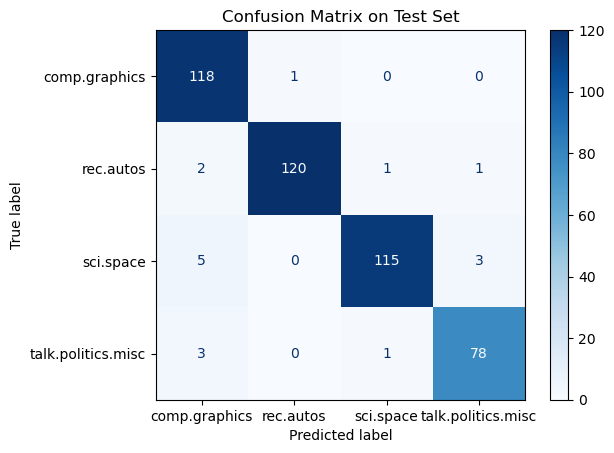

In [23]:
ConfusionMatrixDisplay.from_estimator(best_grid_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.show()

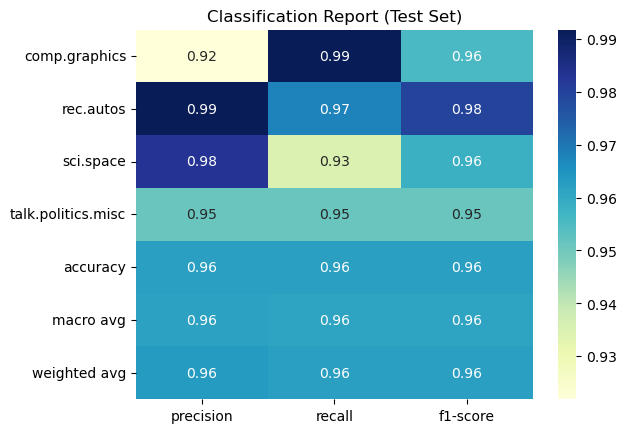

In [24]:
report = classification_report(y_test, best_grid_model.predict(X_test), output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, cmap='YlGnBu')
plt.title("Classification Report (Test Set)")
plt.show()

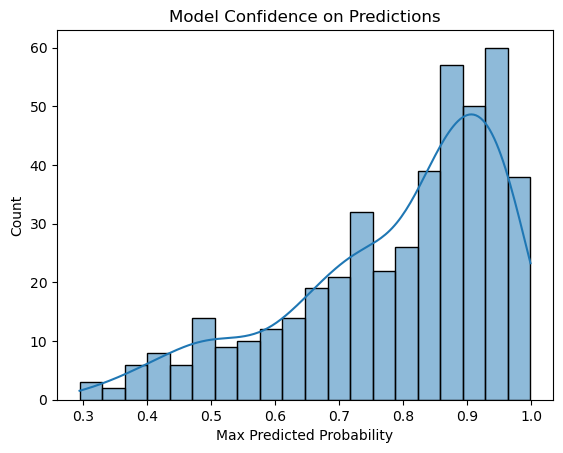

In [25]:
probs = best_grid_model.predict_proba(X_test).max(axis=1)
sns.histplot(probs, bins=20, kde=True)
plt.title("Model Confidence on Predictions")
plt.xlabel("Max Predicted Probability")
plt.ylabel("Count")
plt.show()

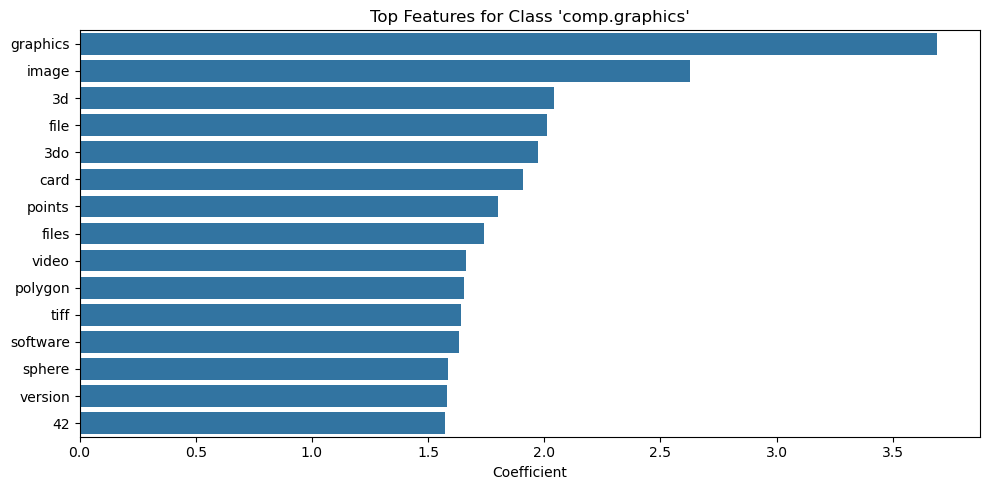

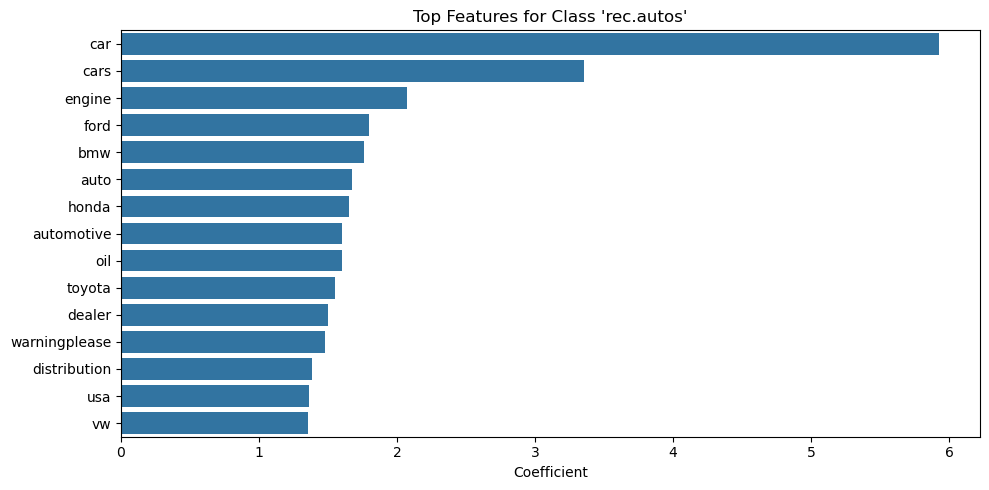

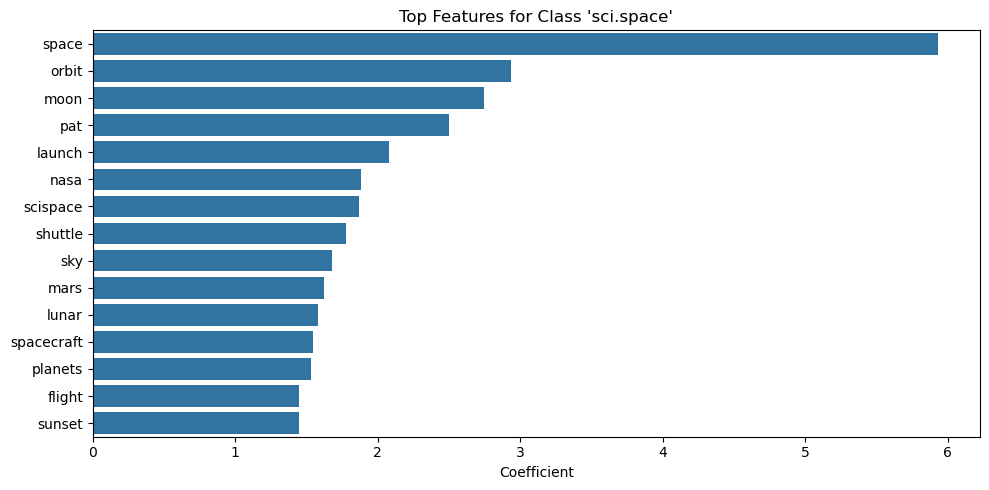

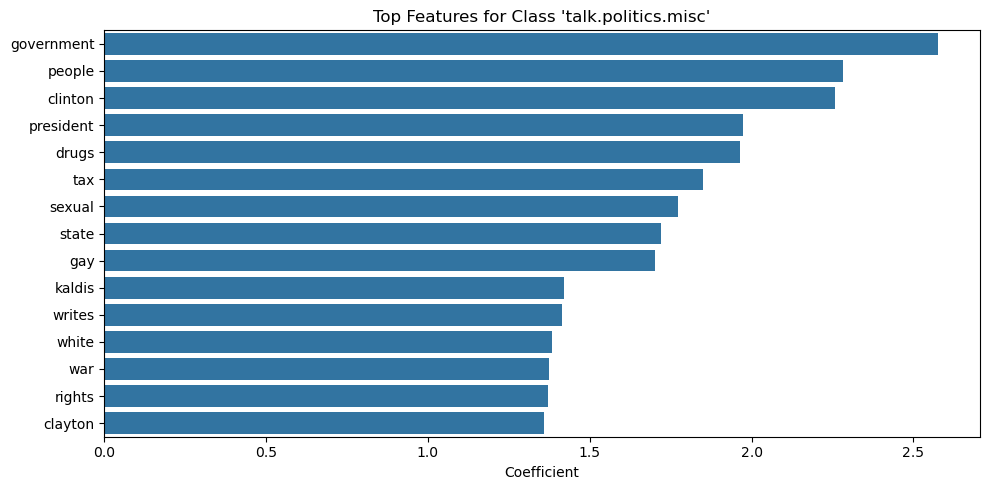

In [26]:
vectorizer = best_grid_model.named_steps['tfidf']
classifier = best_grid_model.named_steps['clf']
feature_names = np.array(vectorizer.get_feature_names_out())

for i, class_label in enumerate(classifier.classes_):
    top_n = 15
    top_indices = classifier.coef_[i].argsort()[::-1][:top_n]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=classifier.coef_[i][top_indices], y=feature_names[top_indices])
    plt.title(f"Top Features for Class '{class_label}'")
    plt.xlabel("Coefficient")
    plt.tight_layout()
    plt.show()

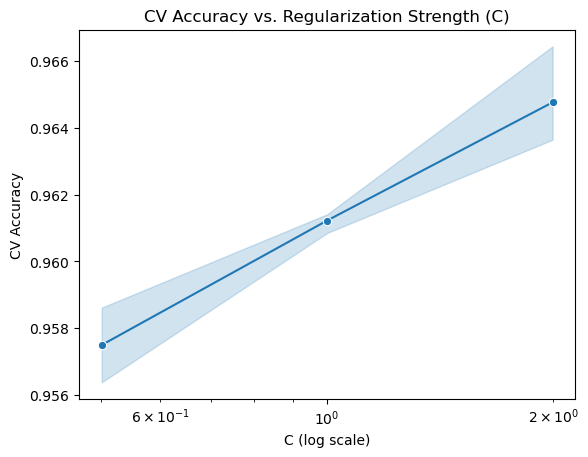

In [27]:
results = pd.DataFrame(grid_search.cv_results_)
sns.lineplot(data=results, x='param_clf__C', y='mean_test_score', marker='o')
plt.xscale('log')
plt.title("CV Accuracy vs. Regularization Strength (C)")
plt.xlabel("C (log scale)")
plt.ylabel("CV Accuracy")
plt.show()

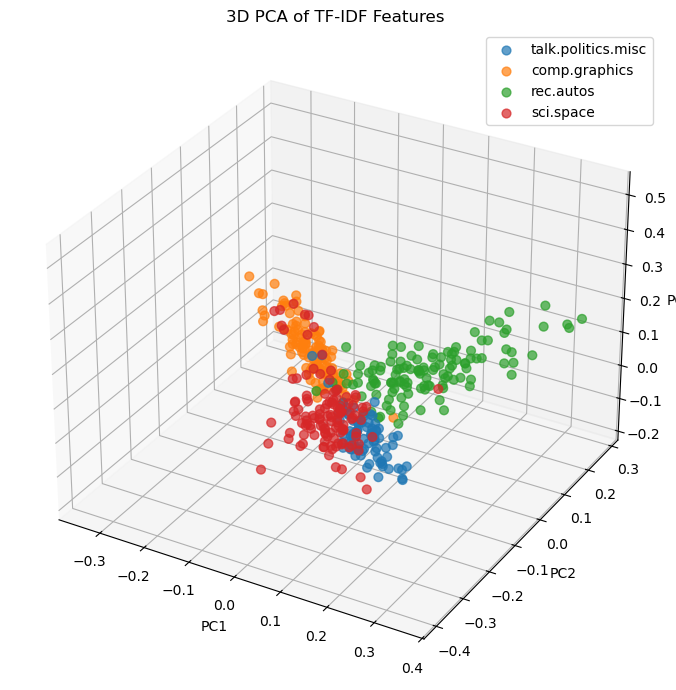

In [28]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get TF-IDF transformed test data
vectorizer = best_grid_model.named_steps['tfidf']
X_test_tfidf = vectorizer.transform(X_test)

# Apply PCA to reduce to 3 dimensions
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_test_tfidf.toarray())

# Convert to DataFrame for easier plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
pca_df['Category'] = y_test.values

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
colors = sns.color_palette('tab10', len(pca_df['Category'].unique()))

for i, category in enumerate(pca_df['Category'].unique()):
    subset = pca_df[pca_df['Category'] == category]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'], 
               label=category, s=40, alpha=0.7, color=colors[i])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("3D PCA of TF-IDF Features")
ax.legend()
plt.tight_layout()
plt.show()

PCA reduction to 3 features showed strong classification. Could be worth exploring with more time

In [29]:
stop_cleaner = TextCleaner(remove_stopwords=True, lemmatize=False)
df['stop_processed_tokens'] = stop_cleaner.transform(df['text'])
df['stop_processed_tokens_list'] = df['stop_processed_tokens'].apply(lambda x: x.split())

lem_cleaner = TextCleaner(remove_stopwords=False, lemmatize=True)
df['lem_processed_tokens'] = lem_cleaner.transform(df['text'])
df['lem_processed_tokens_list'] = df['lem_processed_tokens'].apply(lambda x: x.split())

both_cleaner = TextCleaner(remove_stopwords=True, lemmatize=True)
df['both_processed_tokens'] = both_cleaner.transform(df['text'])
df['both_processed_tokens_list'] = df['both_processed_tokens'].apply(lambda x: x.split())

clean_list = ['processed_tokens', 'stop_processed_tokens', 'lem_processed_tokens', 'both_processed_tokens']

results_summary = []

for cleaner in clean_list:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('clf', LogisticRegression(max_iter=500))
    ])
    
    X = df[cleaner].tolist()
    y = df['category']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
    # Define parameter distribution for RandomizedSearch
    param_dist = {
        'tfidf__max_features': randint(500, 3000),                                # random int between 500 and 3000
        'tfidf__ngram_range': [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)],        # unigrams, bigrams, trigrams
        'tfidf__min_df': randint(1, 10),                                          # min document frequency between 1 and 10
        'clf__C': np.logspace(-3, 3, 7),                                          # regularization strength for Logistic Regression
        'clf__penalty': ['l2'],                                                   # penalty type (can add 'l1' with solver='liblinear')
        'clf__solver': ['lbfgs']                                                  # solver compatible with l2 penalty
    }
    
    # Setup RandomizedSearchCV
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=10,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Run random search on training data
    random_search.fit(X_train, y_train)
    
    print("Best random parameters found:")
    best_params = random_search.best_params_
    print(best_params)
    
    print(f"Best CV accuracy: {random_search.best_score_:.4f}")
    
    # Evaluate on test set
    best_model = random_search.best_estimator_
    test_accuracy = best_model.score(X_test, y_test)
    print(f"Test accuracy: {test_accuracy:.4f}")
    
    param_grid = {
        'clf__C': create_param_grid_around_value('clf__C', best_params['clf__C'], scale=0.3, num_points=3, log_scale=True),
        'tfidf__max_features': create_param_grid_around_value('tfidf__max_features', best_params['tfidf__max_features'], scale=200, num_points=3, log_scale=False),
        'tfidf__min_df': [best_params['tfidf__min_df']],  # Fix this param for now
        'tfidf__ngram_range': [best_params['tfidf__ngram_range']],  # Fix this as well
        'clf__penalty': [best_params['clf__penalty']],
        'clf__solver': [best_params['clf__solver']]
    }
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        error_score='raise'
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters from grid search {cleaner}:")
    print(grid_search.best_params_)
    
    print(f"Best CV accuracy from grid search: {grid_search.best_score_:.4f}")
    
    # Evaluate on test set
    best_grid_model = grid_search.best_estimator_
    test_accuracy = best_grid_model.score(X_test, y_test)
    print(f"Test accuracy with grid search model: {test_accuracy:.4f}")

    results_summary.append({
        "variant": cleaner,
        "cv_acc_random": random_search.best_score_,
        "test_acc_random": best_model.score(X_test, y_test),
        "cv_acc_grid": grid_search.best_score_,
        "test_acc_grid": best_grid_model.score(X_test, y_test)
    })

results_df = pd.DataFrame(results_summary)
print(results_df.sort_values(by="test_acc_grid", ascending=False))

Best random parameters found:
{'clf__C': 1000.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'tfidf__max_features': 2360, 'tfidf__min_df': 4, 'tfidf__ngram_range': (1, 2)}
Best CV accuracy: 0.9597
Test accuracy: 0.9531
Best parameters from grid search processed_tokens:
{'clf__C': 501.18723362727246, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'tfidf__max_features': 2560, 'tfidf__min_df': 4, 'tfidf__ngram_range': (1, 2)}
Best CV accuracy from grid search: 0.9648
Test accuracy with grid search model: 0.9576
Best random parameters found:
{'clf__C': 100.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'tfidf__max_features': 2881, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
Best CV accuracy: 0.9692
Test accuracy: 0.9665
Best parameters from grid search stop_processed_tokens:
{'clf__C': 100.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'tfidf__max_features': 2881, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
Best CV accuracy from grid search: 0.9692
Test accuracy with grid 

Running the same test as above without the filter we created. Strong results across the board but favored either lemmatize or stopword removal, but not both.

In [33]:
cleaners = {
    'processed_tokens': TextCleaner(remove_stopwords=False, lemmatize=False),
    'stop_processed_tokens': TextCleaner(remove_stopwords=True, lemmatize=False),
    'lem_processed_tokens': TextCleaner(remove_stopwords=False, lemmatize=True),
    'both_processed_tokens': TextCleaner(remove_stopwords=True, lemmatize=True)
}

filtered_summary = []

for variant_name, cleaner in cleaners.items():
    # Step 1: Clean
    df[variant_name] = cleaner.transform(df['text'])
    df[variant_name + '_list'] = df[variant_name].apply(lambda x: x.split())
    
    # Step 2: Filter with Category-level TF-IDF filter
    tfidf_filter = CategoryTfidfFilter(category_col='category', text_col=variant_name + '_list', max_features=1000)
    df[variant_name + '_filtered'] = tfidf_filter.fit_transform(df)
    df[variant_name + '_filtered_list'] = df[variant_name + '_filtered'].apply(lambda x: x.split())
    
    # Step 3: Model training and evaluation
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('clf', LogisticRegression(max_iter=500))
    ])
    
    X = df[variant_name + '_filtered'].tolist()
    y = df['category']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    param_dist = {
        'tfidf__max_features': randint(500, 3000),
        'tfidf__ngram_range': [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)],
        'tfidf__min_df': randint(1, 10),
        'clf__C': np.logspace(-3, 3, 7),
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs']
    }
    
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=10,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    
    random_search.fit(X_train, y_train)
    
    best_params = random_search.best_params_
    best_model = random_search.best_estimator_

    param_grid = {
        'clf__C': create_param_grid_around_value('clf__C', best_params['clf__C'], scale=0.3, num_points=3, log_scale=True),
        'tfidf__max_features': create_param_grid_around_value('tfidf__max_features', best_params['tfidf__max_features'], scale=200, num_points=3, log_scale=False),
        'tfidf__min_df': [best_params['tfidf__min_df']],
        'tfidf__ngram_range': [best_params['tfidf__ngram_range']],
        'clf__penalty': [best_params['clf__penalty']],
        'clf__solver': [best_params['clf__solver']]
    }

    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        error_score='raise'
    )
    
    grid_search.fit(X_train, y_train)
    best_grid_model = grid_search.best_estimator_
    
    filtered_summary.append({
        "variant": variant_name,
        "cv_acc_random": random_search.best_score_,
        "test_acc_random": best_model.score(X_test, y_test),
        "cv_acc_grid": grid_search.best_score_,
        "test_acc_grid": best_grid_model.score(X_test, y_test)
    })
    
    print(f"\nResults for {variant_name}:")
    print(f"Best random CV accuracy: {random_search.best_score_:.4f}")
    print(f"Test accuracy (random search): {best_model.score(X_test, y_test):.4f}")
    print(f"Best grid CV accuracy: {grid_search.best_score_:.4f}")
    print(f"Test accuracy (grid search): {best_grid_model.score(X_test, y_test):.4f}")

# Summarize all results
filtered_results_df = pd.DataFrame(filtered_summary)
print("\nFinal summary:")
print(filtered_results_df.sort_values(by='test_acc_grid', ascending=False))


Results for processed_tokens:
Best random CV accuracy: 0.9424
Test accuracy (random search): 0.9420
Best grid CV accuracy: 0.9424
Test accuracy (grid search): 0.9420

Results for stop_processed_tokens:
Best random CV accuracy: 0.9228
Test accuracy (random search): 0.9196
Best grid CV accuracy: 0.9318
Test accuracy (grid search): 0.9330

Results for lem_processed_tokens:
Best random CV accuracy: 0.9446
Test accuracy (random search): 0.9464
Best grid CV accuracy: 0.9446
Test accuracy (grid search): 0.9464

Results for both_processed_tokens:
Best random CV accuracy: 0.9424
Test accuracy (random search): 0.9464
Best grid CV accuracy: 0.9424
Test accuracy (grid search): 0.9464

Final summary:
                 variant  cv_acc_random  test_acc_random  cv_acc_grid  \
2   lem_processed_tokens       0.944636         0.946429     0.944636   
3  both_processed_tokens       0.942397         0.946429     0.942397   
0       processed_tokens       0.942394         0.941964     0.942394   
1  stop_pr

Comparing with same results but with filtered words based on categorical TF-IDF scores

In [34]:
# Set 'variant' as index
results_df = results_df.set_index('variant')
filtered_results_df = filtered_results_df.set_index('variant')

# Add filter labels
results_df['filter'] = 'Unfiltered'
filtered_results_df['filter'] = 'Filtered'

# Reset index before concatenation so 'variant' is a column again
results_df = results_df.reset_index()
filtered_results_df = filtered_results_df.reset_index()

# Concatenate both DataFrames
combined_df = pd.concat([results_df, filtered_results_df], ignore_index=True)

print(combined_df)


                 variant  cv_acc_random  test_acc_random  cv_acc_grid  \
0       processed_tokens       0.959725         0.953125     0.964762   
1  stop_processed_tokens       0.969239         0.966518     0.969239   
2   lem_processed_tokens       0.962523         0.966518     0.963083   
3  both_processed_tokens       0.958604         0.962054     0.961404   
4       processed_tokens       0.942394         0.941964     0.942394   
5  stop_processed_tokens       0.922821         0.919643     0.931765   
6   lem_processed_tokens       0.944636         0.946429     0.944636   
7  both_processed_tokens       0.942397         0.946429     0.942397   

   test_acc_grid      filter  
0       0.957589  Unfiltered  
1       0.966518  Unfiltered  
2       0.966518  Unfiltered  
3       0.959821  Unfiltered  
4       0.941964    Filtered  
5       0.933036    Filtered  
6       0.946429    Filtered  
7       0.946429    Filtered  


In [38]:
combined_df.head(8)

,variant,cv_acc_random,test_acc_random,cv_acc_grid,test_acc_grid,filter
0,processed_tokens,0.959725,0.953125,0.964762,0.957589,Unfiltered
1,stop_processed_tokens,0.969239,0.966518,0.969239,0.966518,Unfiltered
2,lem_processed_tokens,0.962523,0.966518,0.963083,0.966518,Unfiltered
3,both_processed_tokens,0.958604,0.962054,0.961404,0.959821,Unfiltered
4,processed_tokens,0.942394,0.941964,0.942394,0.941964,Filtered
5,stop_processed_tokens,0.922821,0.919643,0.931765,0.933036,Filtered
6,lem_processed_tokens,0.944636,0.946429,0.944636,0.946429,Filtered
7,both_processed_tokens,0.942397,0.946429,0.942397,0.946429,Filtered


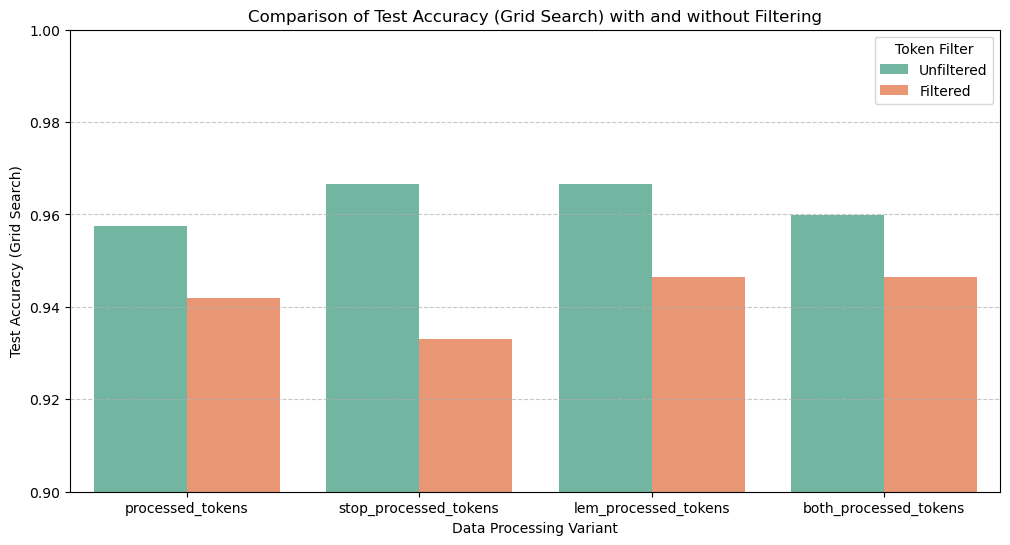

In [35]:
plt.figure(figsize=(12, 6))

sns.barplot(
    data=combined_df,
    x='variant',
    y='test_acc_grid',
    hue='filter',
    palette='Set2'
)

plt.title('Comparison of Test Accuracy (Grid Search) with and without Filtering')
plt.ylabel('Test Accuracy (Grid Search)')
plt.xlabel('Data Processing Variant')
plt.ylim(0.9, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Token Filter')
plt.show()


Here we can see the strongest results came from unfiltered tokens with either stop word removal or lemmatization. Interesting that where we applied both, accuracy fell. 

Maybe the filter parameters could be adjusted for better performance, but the unfiltered performs very well with 96.7% accuracy on both stop removal tokens and lemmatized tokens. Perhaps not filtering out words that had with low STDev just because they had high general TF-IDF scores was the issue. Words like line, etc were left in because they appeared in every doc, so just because they were not adding much they were frequent enough to pass the filter.

The goal was that category-level TF-IDF filtering applied leverages this domain-specific vocabulary variation by selecting terms important per category. That did not seem to be true after fitting the model but the framework is there to be improved.

Stopword removal can help reduce noise but might remove subtle stylistic cues useful for classification.

Lemmatization grouped word forms (e.g., “runs,” “running”) improving generalization but may reduce some nuanced signals.

Overall, the model was still very effective at classifying emails with very slight error that didn't lead towards any particular category. Solid generalization was achieved, and with minor tweaks the model could improve.